In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy

df = pandas.read_csv("forHogg.csv")

# show all available data columns
print(list(df.columns))

['id', 'fiducial', 'x', 'y', 'x2', 'y2', 'peak', 'flux', 'xWokMeasMetrology', 'yWokMeasMetrology', 'xWokMeasBOSS', 'yWokMeasBOSS', 'alphaMeas', 'betaMeas', 'xWokDitherFit', 'yWokDitherFit', 'sigmaWokDitherFit', 'configID', 'telAlt', 'telAz', 'telRot', 'FVC_SCL', 'FVC_TRAX', 'FVC_TRAY', 'FVC_ROT', 'fvcImgNum', 'mjd']


Data Description
-----
Each dither measurement has a unique "configID".  Only positioners that had BOSS targets assigned during each dither are included in each configID.  Some amount of outlier rejection was performed in this data set, but nothing to careful...

id: string, unique name for each robot or fiducial

fiducial: bool, true if measurement is for a fiducial.  note, if fiducial==True then alpha/betaMeas, x/yMeasBoss x/yWokDitherFit, sigmaWokDitherFit are NaN

centroid related: (output from python 'sep' program, source extractor https://sep.readthedocs.io/en/v1.0.x/api/sep.extract.html) 

x/y: xy center of centroid on FVC CCD

x2/y2: 2nd moments of centroid

peak: peak counts in centroid

flux: integrated flux

x/yWokMeasMetrology: fit location (including distortion model fit from fiducial fibers) of the centroid in the wok coordinate frame (mm).

alpha/betaMeas: calculated alpha/beta angles for each robot, inferred from x/yWokMeasMetrolgy values

x/yWokMeasBOSS: FVC calculated BOSS fiber location determined from alpha/betaMeas and (known?) relative offset from metrology to BOSS fiber

x/yWokDitherFit: Dither-calculated BOSS fiber location in wok coordinate frame.  Center of 2D gaussian psf model.

sigmaWokDitherFit (mm): best fit std for gaussian psf model (rough estimate for seeing)

configID: integer, unique to a specific robotic (dither) configuration

telAlt/Az/Rot (degrees): telescope pointing at the time of FVC imaging

FVC_SCL/TRAX/TRAY/ROT: best-fit translation/rotation/scale parameters to map FVC pixels to wok mm (no disortion included).

fvcImgNum + mjd: mjd and image number to find the raw FVC image if you want it from Utah.

Caveat
------
xyWokDitherFit locations are better when we actually dither the fiber around the star, sometimes we dither off to one side, but the fiber convolved psf fit still appears reasonable, usually, and if anything it's at least a decent guess at where the BOSS fiber actually is on the focal plane

Tour de Plots
-------------


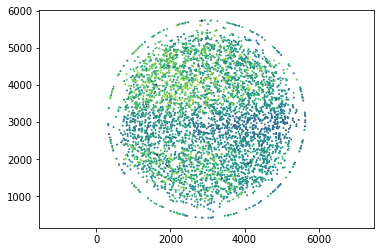

In [2]:
# plot flux as a function of CCD location for all 
# centroid measurments across all dither sequences
plt.figure()
plt.scatter(df.x,df.y,c=df.flux,s=1)
plt.axis("equal")
plt.show()

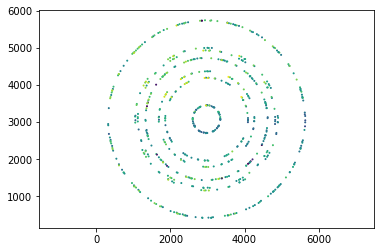

In [3]:
# plot same thing but only for fiducials
_df = df[df.fiducial==True]
plt.figure()
plt.scatter(_df.x,_df.y,c=_df.flux,s=1)
plt.axis("equal")
plt.show()

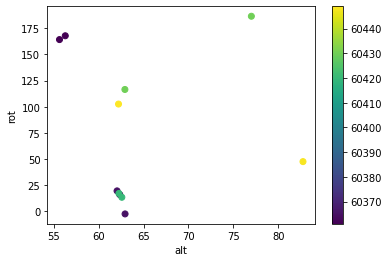

In [4]:
# plot distribution of telescope alt and rot where fvc images were taken
# color by mjd
_df = df.groupby("configID").first()
plt.figure()
plt.scatter(_df.telAlt, _df.telRot, c=_df.mjd)
plt.xlabel("alt")
plt.ylabel("rot")
plt.colorbar()
plt.show()

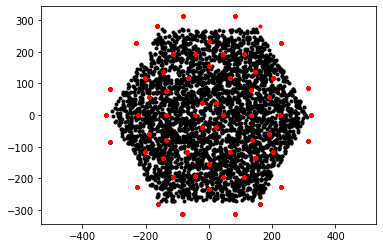

In [5]:
# plot all detections in the distortion-fit wok coordinate frame
# black spots for metrology fibers, red spots for fiducial fibers
plt.figure()
_df = df[df.fiducial==False]
plt.plot(_df.xWokMeasMetrology, _df.yWokMeasMetrology, '.k')
_df = df[df.fiducial==True]
plt.plot(_df.xWokMeasMetrology, _df.yWokMeasMetrology, '.r')
plt.axis("equal")
plt.show()

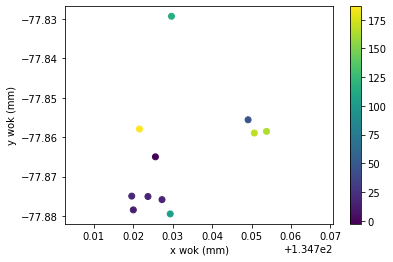

In [6]:
# visualize scatter in a single fiducial measurement across mutiple configurations
# fiducials should be fixed, so this says something about the variance 
# in the fvc mapping from pixels to wok
# color by rotator angle
_df = df[df.id=="F201781"] # a random fiducial
plt.figure()
plt.scatter(_df.xWokMeasMetrology, _df.yWokMeasMetrology, c=_df.telRot)
plt.axis("equal")
plt.xlabel("x wok (mm)")
plt.ylabel("y wok (mm)")
plt.colorbar()
plt.show()

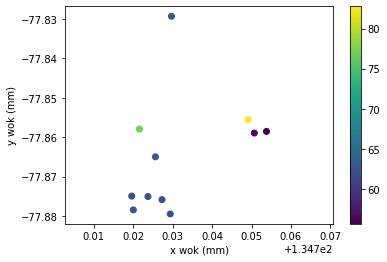

In [7]:
# visualize scatter in a single fiducial measurement across mutiple configurations
# fiducials should be fixed in the wok frame, so this says something about the variance 
# in the fvc mapping from pixels to wok
# color by telescope altitude
_df = df[df.id=="F201781"] # a random fiducial
plt.figure()
plt.scatter(_df.xWokMeasMetrology, _df.yWokMeasMetrology, c=_df.telAlt)
plt.axis("equal")
plt.xlabel("x wok (mm)")
plt.ylabel("y wok (mm)")
plt.colorbar()
plt.show()

Main Issue
----------
We want the FVC to estimate the same BOSS fiber location (using fiducials and metrology fiber spots) as the dither results.  If we do that fiber positioning should improve.

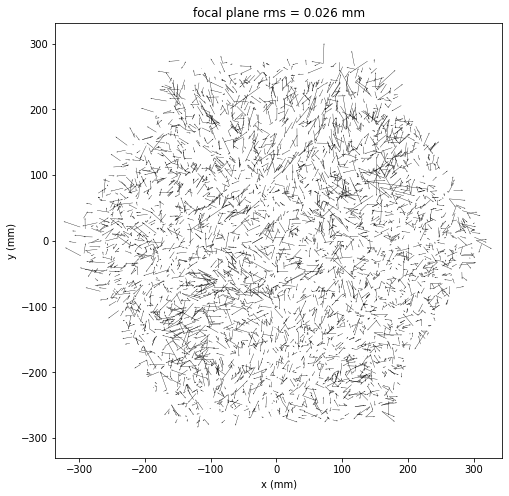

In [12]:
# plot the difference between the FVC-assumed BOSS fiber locations, and the dither-measured
# boss fiber locations
# assume that dither measurements are accurate ?
_df = df[df.fiducial==False]
xyDither = _df[["xWokDitherFit", "yWokDitherFit"]].to_numpy()
xyFVC = _df[["xWokMeasBOSS", "yWokMeasBOSS"]].to_numpy()
dxy = xyFVC - xyDither
rms = numpy.sqrt(numpy.mean(numpy.sum(dxy**2,axis=1)))
plt.figure(figsize=(8,8))
plt.quiver(xyDither[:,0], xyDither[:,1], dxy[:,0], dxy[:,1], angles="xy", units="xy", scale=0.002, width=0.5)
plt.axis("equal")
plt.title("focal plane rms = %.3f mm"%(rms))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.show()



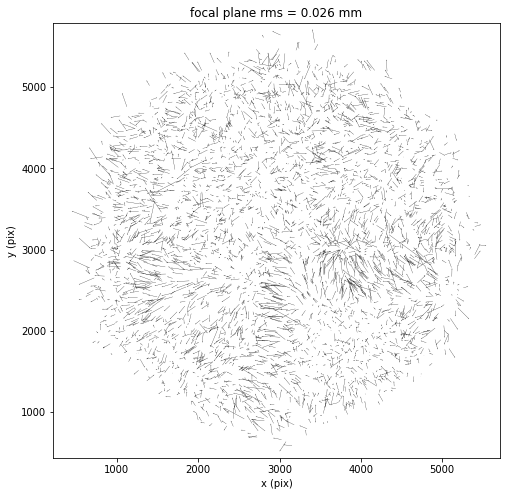

In [15]:
# rotate error vectors back into the FVC frame
fvcRot = -1*numpy.radians(_df.FVC_ROT)
cosRot = numpy.cos(fvcRot)
sinRot = numpy.sin(fvcRot)
dxFVC = dxy[:,0]*cosRot - dxy[:,1]*sinRot
dyFVC = dxy[:,0]*sinRot + dxy[:,1]*cosRot
plt.figure(figsize=(8,8))
plt.quiver(_df.x, _df.y, dxFVC, dyFVC, angles="xy", units="xy", scale=0.0003, width=3)
plt.axis("equal")
plt.title("focal plane rms = %.3f mm"%(rms))
plt.xlabel("x (pix)")
plt.ylabel("y (pix)")
plt.show()

Clear spatial coherence in FVC frame (could be modeled further?).  I'm hoping that moving the FVC this summer will help...fiber imaging at the same rotator angle may also help cut down on variance, but adds overheads during field setup...